# Fig 5: Prediction of cell-to-cell variability from fitted models


This notebook is used to compare the fitted models to the gaussian process output

# Setup and load data

In [11]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,Random,Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

In [12]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);
unique(data_gp.length)
names(data_gp)

14-element Vector{String}:
 "matern32_cell"
 "matern32_cell_var"
 "matern32_cell_x"
 "matern32_cell_x_var"
 "matern32_flucs"
 "matern32_flucs_var"
 "matern32_flucs_x"
 "matern32_flucs_x_var"
 "time"
 "position"
 "linear"
 "lineage"
 "age"
 "length"

# Prediction of variance of cell-cycle averaged growth

## Setup

we load simulated data which has been fit to instantaneous growth rates

In [13]:
data_cells = combine(groupby(data_gp,[:lineage,:position]),
    :matern32_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
lineages = unique(data_cells.lineage)
# get time interval for predicted arrays
dt = mean(diff(data_gp[data_gp.lineage .== lineages[1],:time])); 

# get sims
sims = CSV.read("./../output/fig5_sims.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:σDN,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original

48010-element Vector{Int64}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 22
 22
 22
 22
 22
 22
 22
 22
 22

In [14]:
length(unique(sims[sims.lineage_original .== 1,:].lineage))

300

In [15]:
unique(sims.replicate)

20-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

## Visual Comparison of simulations to data

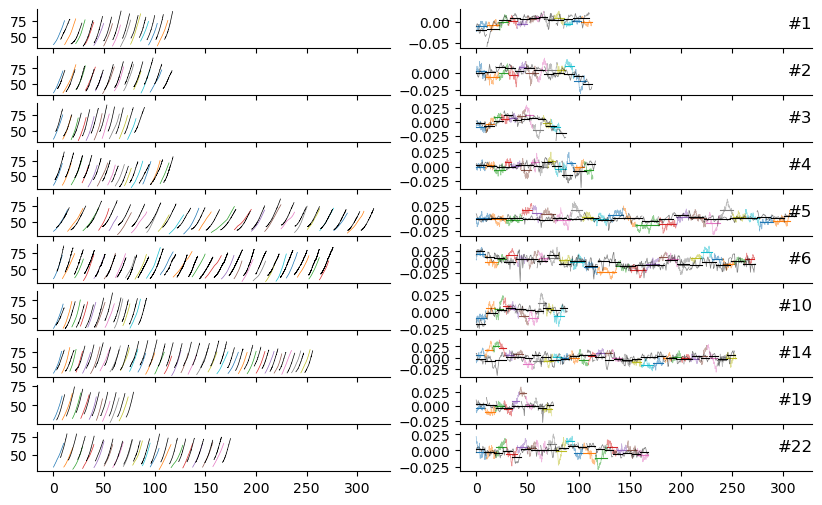

In [16]:
lw=0.5
fig,axs =subplots(figsize=(10,6),nrows=length(lineages),sharex="col",ncols=2)
for i in eachindex(lineages)
    lin = lineages[i]

    # ------------------------------------------
    ax = axs[i-1,0]

    sims1 = sims[sims.lineage_original .==lin,:]
    sims1 = sims1[sims1.σDN .== 0.0,:]
    
    
    #dd = data_gp[data_gp.lineage .==lin,:]
    dd = data_raw[data_raw.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    #dd.λ = vcat([dd[dd.position .== p,:].matern32_flucs_x .+ dd[dd.position .== p,:].matern32_cell_x ./ dd[dd.position .== p,:gen_time][1]  for p in unique(dd.position)]...)
    #dd.λ = dd.matern32_flucs_x
    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        [ax.plot(ds[ds.position .==p,:].time,ds[ds.position .==p,:].M,lw=0.5) for p in unique(ds.position)]
    end
    [ax.plot(dd[dd.position .==p,:].time,dd[dd.position .==p,:].M,"k",lw=0.5) for p in unique(dd.position)]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)


    # ------------------------------------------
    ax = axs[i-1,1]

 

    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        for p in unique(ds.position)
            t = ds[ds.position .==p,:].time
            λ =  ds[ds.position .==p,:].λ
            λ  = λ .- mean(ds.λ)
            ax.plot(t,λ ,"C"*string(Int64(p))*"-",lw=lw,alpha=0.5)
            ax.plot(t,mean(λ) .*ones(length(t)),"C"*string(Int64(p))*"-",lw=0.8)
        end
    end
    
    dd = data_gp[data_gp.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    dd.λ = dd.matern32_flucs_x
    for p in unique(dd.position)
        t = dd[dd.position .==p,:].time
        ax.plot(t,dd[dd.position .==p,:].λ,"k-",lw=lw,alpha=0.5)
        ax.plot(t,mean(dd[dd.position .==p,:].λ) .*ones(length(t)),"k-",lw=0.8)
    end
    ax.set_title("#"*string(Int64(lin)),y=1.0, pad=-14,loc="right")
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)

  
end

#axs[length(lineages)-1,0].set_xlabel("time [hours]")
#axs[length(lineages)-1,1].set_xlabel("time [hours]")
savefig("./../figures/OU_vs_data.pdf")
fig